## Day 31 Lecture 1 Assignment

In this assignment, we will learn about the K nearest neighbor algorithm. We will use the titanic dataset and create a model that can predict if a passenger will survive the Titanic Shipwreck or not {0, 1}.

In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score

Columns:
- 'PassengerId': id of the passenger
- 'Survived': 
- 'Pclass': Ticket class
- 'Name': Name
- 'Sex': sex
- 'Age': Age in years
- 'SibSp': # of siblings / spouses aboard the Titanic
- 'Parch': # of parents / children aboard the Titanic
- 'Ticket': 
- 'Fare': Passenger fare
- 'Cabin': Cabin number
- 'Embarked': Port of Embarkation

In [72]:
data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/titanic.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


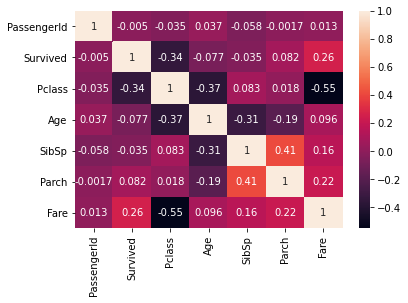

In [74]:
sns.heatmap(data.corr(), annot=True)
plt.show()

We check the distribution of variables for the column we want to predict.

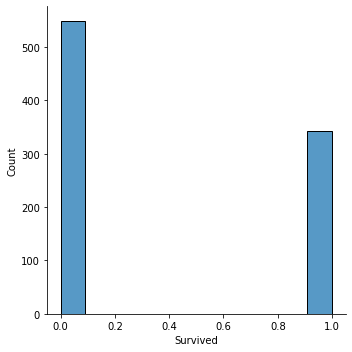

In [75]:
# Calculate value counts for the Survived column
sns.displot(data['Survived'])
plt.show()

In [76]:
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

First, check for missing data and remove all columns containing missing data

In [77]:
# Calculate NA values per column
missing_data = data.isnull().sum()/data.isnull().shape[0]
missing_data

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [78]:
for i in missing_data.index:
  if missing_data[i] != 0:
    data.drop(i, 1, inplace=True)

In [79]:
missing_data = data.isnull().sum()/data.isnull().shape[0]
missing_data

PassengerId    0.0
Survived       0.0
Pclass         0.0
Name           0.0
Sex            0.0
SibSp          0.0
Parch          0.0
Ticket         0.0
Fare           0.0
dtype: float64

We also drop columns that are not informative and contain too many unique values(e.g. name)

In [80]:
# Calculate unique values for each column
data['PassengerId'] = data['PassengerId'].astype('str')
print('\n'.join([f"Column with name '{c}' has {data[c].nunique()} unique values" for c in data.select_dtypes(include='O').columns]))    

Column with name 'PassengerId' has 891 unique values
Column with name 'Name' has 891 unique values
Column with name 'Sex' has 2 unique values
Column with name 'Ticket' has 681 unique values


In [81]:
# Drop columns 'PassengerId', 'Name' and 'Ticket'.
data.drop(['PassengerId', 'Name', 'Ticket'], 1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   SibSp     891 non-null    int64  
 4   Parch     891 non-null    int64  
 5   Fare      891 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 41.9+ KB


To use the data, we must convert all columns to numeric. Do this by replacing yes and no with 1 and 0.

In [82]:
# Use get_dummies to get a dataset with one hot encoded columns for categorical variables
# Survived should be excluded.
data= pd.concat([data, pd.get_dummies(data['Sex'], prefix='is', drop_first=True)], axis = 1)
data.drop('Sex', 1, inplace=True)

In [83]:
# Let's check the new columns
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   SibSp     891 non-null    int64  
 3   Parch     891 non-null    int64  
 4   Fare      891 non-null    float64
 5   is_male   891 non-null    uint8  
dtypes: float64(1), int64(4), uint8(1)
memory usage: 35.8 KB


,Survived,Pclass,SibSp,Parch,Fare,is_male
0,0,3,1,0,7.2500,1
1,1,1,1,0,71.2833,0
2,1,3,0,0,7.9250,0
3,1,1,1,0,53.1000,0
4,0,3,0,0,8.0500,1


Split the data into train and test. Use 20% of the data for our test subset. We will use the train_test_split function from scikit-learn for this.

In [84]:
# Split the dataset. Remember that the y arrays should include only the 'Survived' column which should be excluded from
# the X arrays
Y = data['Survived']
X = data.drop('Survived',1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

Generate a KNN model with k=1 for the dataset. What is the accuracy score for the train and test subsamples?

In [85]:
# answer below:
neighbors = KNeighborsClassifier(n_neighbors=1)

neighbors.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [88]:
print(f'Train Score: {neighbors.score(X_train, y_train)}')
print(f'Train Score: {neighbors.score(X_test, y_test)}')

AttributeError: ignored

Would you say the model overfits? Why or why not? Put your answer in the comment below.

**Definitely overfits because k is just 1, so it only compares to the actual nearest neighbor, which would include outliers in the training data.**

Let's optimize k. A good idea is to create plots that depict train and test accuracy for each candidate k. Since we have 2 classes, we will be selecting odd numbers in order to deal with possible ties. By selecting a really small k, e.g. k=1, we increase variance and the model is prone to overfitting since it will only take into account the nearest neighbor where there could be a lot of other close samples belonging to another class. By doing the opposite, selecting a big k we are prone to underfitting, as we increase bias as there is a higher probability to select the majority class.


For each k value in the list created above we want to create and fit a knn instance on X_train, y_train and then make predictions both on the training set (X_train) as well as on the test set(X_test) and calculate accuracy and f1 score and append it to the corrensponding list.

In [90]:
accuracy_train = []
accuracy_test = []
f1_train = []
f1_test = []
k_list = range(1, 15, 2)

for k in range(1,15,2):
  neighbors = KNeighborsClassifier(n_neighbors=k)
  neighbors.fit(X_train,y_train)
  y_pred_train = neighbors.predict(X_train)
  y_pred_test = neighbors.predict(X_test)
  accuracy_train.append(accuracy_score(y_train, y_pred_train))
  accuracy_test.append(accuracy_score(y_test, y_pred_test))
  f1_train.append(f1_score(y_train, y_pred_train))
  f1_test.append(f1_score(y_test, y_pred_test))


In the following plot we want to select the k that achieves the highest test score. 

Create a two plots with each of them depicting the following information:
1. Two lines, one for training accuracy and one for test accuracy for each k value.
2. Two lines, one for training F1score and one for test F1 score for each k value.

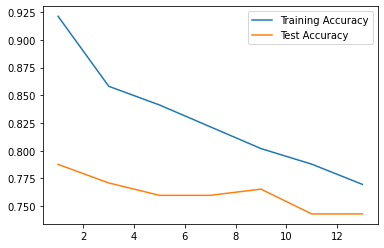

In [98]:
# answer below:
plt.plot(range(1,15,2), accuracy_train, label='Training Accuracy')
plt.plot(range(1,15,2), accuracy_test, label='Test Accuracy')
plt.legend()
plt.show()


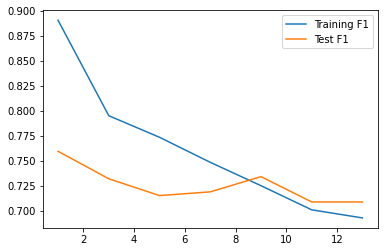

In [95]:
plt.plot(range(1,15,2), f1_train, label='Training F1')
plt.plot(range(1,15,2), f1_test, label='Test F1')
plt.legend()
plt.show()

Please comment the results of the plots above

**k=9 would be the best k, but this should be confirmed with cross-validation.**

In [108]:
neighbors = KNeighborsClassifier()
params = {'n_neighbors': k_list}
knn_grid = GridSearchCV(neighbors, param_grid = params, cv=5)

knn_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 15, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [109]:
y_pred_train = knn_grid.predict(X_train)
y_pred_test = knn_grid.predict(X_test)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))
print(f1_score(y_train, y_pred_train))
print(f1_score(y_test, y_pred_test))

0.8412921348314607
0.7597765363128491
0.7735470941883769
0.7152317880794703


In [110]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [111]:
neighbors = KNeighborsClassifier()
params = {'n_neighbors': k_list}
knn_grid = GridSearchCV(neighbors, param_grid = params, cv=5, scoring='f1')

knn_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 15, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [112]:
y_pred_train = knn_grid.predict(X_train)
y_pred_test = knn_grid.predict(X_test)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))
print(f1_score(y_train, y_pred_train))
print(f1_score(y_test, y_pred_test))

0.8412921348314607
0.7597765363128491
0.7735470941883769
0.7152317880794703


In [113]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')